Method for estimating the canopy cover of a 20x20 meters area using LiDAR data. 

Given this 20x20 meters area, the canopy cover is estimated as the percentage of points that are from a given class (in this case class = 5, as it is vegetation >3m) inside each point. 

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import time
from GFire_utils.AllFunctions import *

pd.set_option('display.max_columns', None)

In [11]:
# Hyperparameters
x_coord = 'x'
y_coord = 'y'
z_coord = 'z'
lidar_columns = [x_coord, y_coord, z_coord, 'class']
groundtruth_columns = [x_coord, y_coord, 'CC']
outliers = 135

gt_inc = 20 # Meters increment of each point of the lidar blocks

gt_centered = True # True if the coordenates of the gt are the center of the block. False if are the bottom-left edge

vegetation = [5]

In [12]:
# LiDAR and groundtruth reading
my_block = pd.read_csv('../toy dataset/input_toydataset.txt', sep=' ', header = None, names = lidar_columns)
groundtruth = pd.read_csv('../toy dataset/groundtruth_toydataset.csv', sep=' ', header = None, names = groundtruth_columns)

In [13]:
# Fixing formats 
if gt_centered:
    groundtruth[x_coord] -= gt_inc/2
    groundtruth[y_coord] -= gt_inc/2
    
# Percentage cannot exceed 100 
aux = groundtruth['CC'].copy()
aux[aux>100] = 100
groundtruth['CC'] = aux

# Dropping outliers
my_block = my_block[my_block['class'] != outliers]

# Matching gt and block
if (my_block[x_coord][0] //gt_inc * gt_inc) % gt_inc != groundtruth[x_coord][0] % gt_inc: 
    # Blocks don't match, ones are even and others are odd
    print("Blocks adjusted")
    adj_x = 2*(my_block[x_coord] % gt_inc > gt_inc/2)-1
    adj_y = 2*(my_block[y_coord] % gt_inc > gt_inc/2)-1
else:
    adj_x = 0
    adj_y = 0

In [14]:
# Grouping points into blocks
my_block['x_p'] = my_block[x_coord]// gt_inc * gt_inc + gt_inc/2 * adj_x
my_block['y_p'] = my_block[y_coord]// gt_inc * gt_inc + gt_inc/2 * adj_y

In [15]:
df_vegetation = my_block[my_block['class'].isin(vegetation)].copy()

df_vegetation = df_vegetation.groupby(['x_p','y_p'])['class'].count().reset_index()
df_vegetation = df_vegetation.rename({'class': 'vegetation_points'}, axis=1)

my_block = my_block.groupby(['x_p','y_p'])['class'].count().reset_index()
my_block = my_block.rename({'class': 'all_points'}, axis=1)

my_block = pd.merge(my_block, df_vegetation, how='left', on = ['x_p','y_p'])
my_block['vegetation_points'].fillna(0, inplace=True)

my_block['predicted_CC'] = 100*my_block['vegetation_points'] / my_block['all_points']

In [16]:
# Merging gt and blocks
groundtruth.columns = ['x_p','y_p','CC']
my_block = pd.merge(my_block, groundtruth, how='inner', on = ['x_p', 'y_p'])

if my_block.shape[0] != groundtruth.shape[0]:
    print("Groundtruth merging done wrong")

In [17]:
# Calculating score
r2 = r2_score(my_block['CC'], my_block['predicted_CC'])

print("R2 score:", r2)

R2 score: 0.6759572549233133


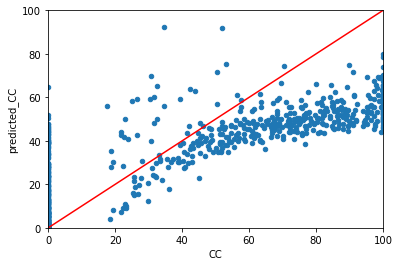

In [18]:
# Plotting the results
my_block.plot.scatter('CC', 'predicted_CC')
plt.xlim(0, 100)
plt.ylim(0,100)
plt.plot([0,100],[0,100], c='r')

plt.show()